# Tapping Synchronisation Aligment Assessment

This notebook describes the way participants motion recordings were brought into alignment with the stimulus/concert time, and the effectiveness of the tapping synchronisation protocol. 

This recreates results shown in /MusicLabCopenhegan_MotionAlignment/Alignment_Describe.ipynb but with new file structures.


In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

In [72]:
def nannotime(row,shift,dshift):
    # function to generate a row of nans with caveats for time fields, which are shifted by a designated ammount 
    r = row.copy()
    cols = r.index
    for c in cols:
        if not c.startswith('time'):
            if c.endswith('datetime'):
                r[c] = r[c] + dshift 
            if not c.endswith('datetime'):
                if c.endswith('timestamps'):
                    r[c] = r[c] + shift 
                if not c.endswith('timestamps'):
                    r[c] = np.nan
        if c.startswith('time'):
            r[c] = r[c] + shift     
    return r

def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    time_col = 'time'
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    
    data = data.append(nannotime(data.iloc[-1,:],deltat,dtdeltat),ignore_index=True)
    
    dt = data[time_col].diff()
    a = list(dt[dt>gap_t].index)
    a.sort(reverse=True)
    for gapi in a:
        data = data.append(nannotime(data.iloc[gapi-1,:],deltat,dtdeltat))
        data = data.append(nannotime(data.iloc[gapi,:],-deltat,dtdeltat))

    data = data.append(nannotime(data.iloc[0,:],-1,dtdeltat)).sort_values(time_col,ignore_index=True)
    return data

In [3]:
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

internal_mlmotion = general_loc + 'Internal/Motion_ML'
public_mlmotion = general_loc + 'Public/Motion_ML'
internal_ax3 = general_loc +  'Internal/Motion_AX3'
public_ax3 = general_loc + 'Public/Motion_AX3'
internal_Part = general_loc + 'Internal/Participants'
public_Part = general_loc + 'Public/Participants'
internal_time = general_loc + 'Internal/Timing'
public_time = general_loc + 'Mobile_data/Public/Timing'

In [196]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)
# device times 10 Hs
ts_dt = pd.date_range(Start_time,End_time, freq='20ms')
ts_ts = np.arange(Start_time.timestamp(),End_time.timestamp(), 0.02)*1000
# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')
#[dt_ct[0],dt_ct[-1]]

concert_times = pd.read_csv(internal_time +'/Events_Full.csv',",",index_col = 0) #SV alignment for beeps
concert_times.iloc[:5]


,time_s,time,events,event_type,Stream_Time_s
datetime,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping,Audience Group,946.00
2021-10-26 17:36:52,-674.12,-674120,Clapping Off,Audience Group,963.12
2021-10-26 17:36:53,-673.12,-673120,Danish,MCing,964.12
2021-10-26 17:37:10,-656.12,-656120,English,MCing,981.12
2021-10-26 17:37:20,-645.60,-645600,Danish,MCing,991.64


In [195]:
partDets = pd.read_csv(internal_Part + '/Map_Internal.csv')#,index_col = 0,header_col = 0)
partDets.columns

Index(['ParticipantCode', 'Unnamed: 1', 'PartN', 'Attendence',
       'Questionnaire_Language', 'Motion_Quality', 'Exclusion', 'temp codes',
       'Paper Q Codes', 'App Q Code', 'Usher Q Code', 'LinkConflicts',
       'Seat by Usher records', 'Seat by Questionnaire', 'Seat Final', 'X',
       'Y', 'SeatZone', 'Location (City)', 'Longitude', 'Lattitude',
       'Longitude_Truncated', 'Lattitude_Truncated', 'All DevID',
       'Motion DevID', 'Aligned DevID', 'Questionnaire NA Count', 'Offset_1',
       'Offset_2'],
      dtype='object')

# Example sensor reading
one participant's motion recording

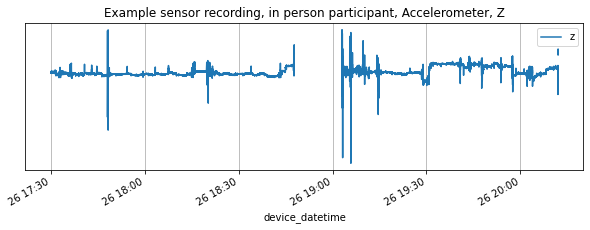

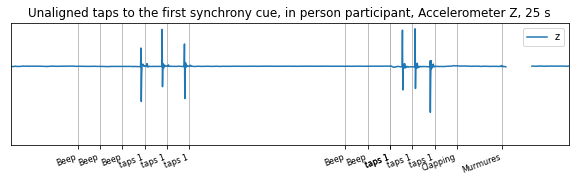

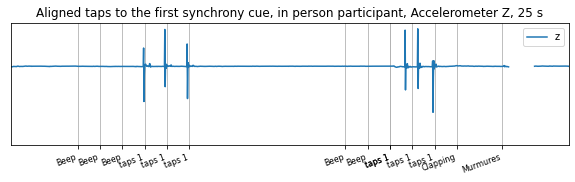

In [176]:
participant = partDets.iloc[6]

folder = internal_mlmotion
file_suffix = '_Mobile_Motion.csv'
inst_d = pd.read_csv(folder + '/' + participant['ParticipantCode'] + file_suffix )
inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
inst_d['device_datetime']=(pd.to_datetime(inst_d['device_timestamps'],unit='ms')) # pull up old device time stamps
inst_d = gap_nans(inst_d,1000)

# testing the 
inst_d.plot.line(x='device_datetime',y='z',figsize=[10,3])
plt.grid()
plt.title('Example sensor recording, in person participant, Accelerometer, Z')
plt.yticks([])
plt.savefig('./plots/SampleACCZ.png',dpi=300)
plt.show()

inst_d.plot.line(x='device_datetime',y='z',figsize=[10,2.5])
plt.yticks([])
plt.title('Unaligned taps to the first synchrony cue, in person participant, Accelerometer Z, 25 s')
plt.xticks(concert_times.index,concert_times.events, rotation='20',fontsize=8)
plt.xlabel('')
plt.xlim([pd.to_datetime('2021-10-26 17:48:00'),pd.to_datetime('2021-10-26 17:48:25')])
plt.grid()
plt.savefig('./plots/SampleACCZ_first_taps.png',dpi=300)
plt.show()


inst_d.plot.line(x='datetime',y='z',figsize=[10,2.5])
plt.yticks([])
plt.title('Aligned taps to the first synchrony cue, in person participant, Accelerometer Z, 25 s')
plt.xticks(concert_times.index,concert_times.events, rotation='20',fontsize=8)
plt.xlabel('')
plt.xlim([pd.to_datetime('2021-10-26 17:48:00'),pd.to_datetime('2021-10-26 17:48:25')])
plt.grid()
#plt.savefig('./plots/SampleACCZ_firsttaps.png',dpi=300)
plt.show()

In [177]:
participant

ParticipantCode                                         ADQ007
Unnamed: 1                                                   7
PartN                                                        7
Attendence                                                   A
Questionnaire_Language                                       D
Motion_Quality                                               Q
Exclusion                                                   No
temp codes                                                D128
Paper Q Codes                                          DSQd128
App Q Code                                             DSQd128
Usher Q Code                                              D128
LinkConflicts                                              0.0
Seat by Usher records                                       D3
Seat by Questionnaire                                       D3
Seat Final                                                  D3
X                                                      

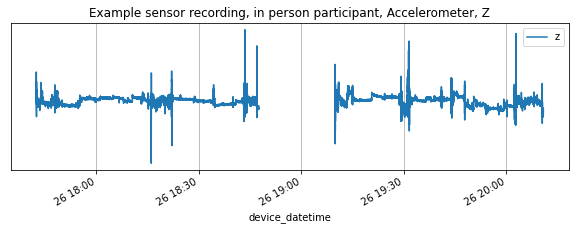

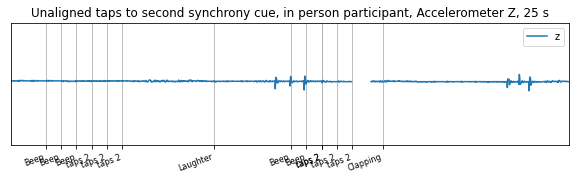

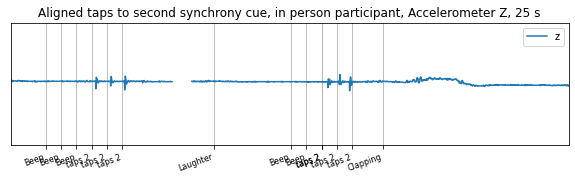

In [178]:
participant = partDets.iloc[96]

folder = internal_mlmotion
file_suffix = '_Mobile_Motion.csv'
inst_d = pd.read_csv(folder + '/' + participant['ParticipantCode'] + file_suffix )
inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
inst_d = gap_nans(inst_d,1000)
inst_d['device_datetime']=(pd.to_datetime(inst_d['device_timestamps'],unit='ms')) # pull up old device time stamps


# testing the 
inst_d.plot.line(x='device_datetime',y='z',figsize=[10,3])
plt.grid()
plt.title('Example sensor recording, in person participant, Accelerometer, Z')
plt.yticks([])
plt.savefig('./plots/SampleACCZ_remote.png',dpi=300)
plt.show()
inst_d.plot.line(x='device_datetime',y='z',figsize=[10,2.5])
plt.yticks([])
plt.title('Unaligned taps to second synchrony cue, in person participant, Accelerometer Z, 25 s')
plt.xticks(concert_times.index,concert_times.events, rotation='20',fontsize=8)
plt.xlabel('')
plt.xlim([inst_d['device_datetime'].iloc[240400],inst_d['device_datetime'].iloc[242500]])
plt.grid()
plt.savefig('./plots/SampleACCZ_secondtaps_Remote.png',dpi=300)
plt.show()

inst_d.plot.line(x='datetime',y='z',figsize=[10,2.5])
plt.yticks([])
plt.title('Aligned taps to second synchrony cue, in person participant, Accelerometer Z, 25 s')
plt.xticks(concert_times.index,concert_times.events, rotation='20',fontsize=8)
plt.xlabel('')
plt.xlim([inst_d['device_datetime'].iloc[240400],inst_d['device_datetime'].iloc[242500]])
plt.grid()
#plt.savefig('./plots/SampleACCZ_secondtaps_Remote.png',dpi=300)
plt.show()

# Assessing phone clock quality from audience alignment results


In [179]:
SynchsAll = partDets.loc[partDets['Motion_Quality']=='Q',['ParticipantCode','Attendence','Motion_Quality','Offset_1','Offset_2']]

In [180]:
Synchs = SynchsAll.loc[SynchsAll['Attendence'] == 'A',['Offset_1','Offset_2']]

print('How many are missing the first synch cue: ' + str((Synchs["Offset_1"]).isna().sum()))
print('How many are missing the second synch cue: ' + str((Synchs["Offset_2"]).isna().sum()))
print('How many have both first and second: ' + str(len(Synchs) - (Synchs["Offset_1"] + Synchs["Offset_2"]).isna().sum()) + ' of ' + str(len(Synchs)))

How many are missing the first synch cue: 6
How many are missing the second synch cue: 9
How many have both first and second: 65 of 80


The mean absolute difference from first to second cue: 0.1436923076923077
The median difference from first to second cue: 0.08000000000000002
The median absolute difference from first to second cue: 0.10000000000000009
The std in difference from first to second cue: 0.2007040492481788
The max absolute difference from first to second cue: 0.9
The max difference from first to second cue: 0.48000000000000004
The min difference from first to second cue: -0.9


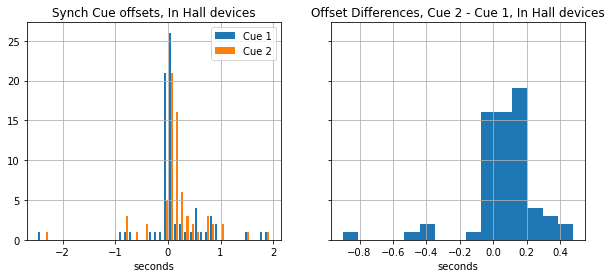

,Means,Medians,Means (abs),Medians (abs),Stds,Mins,Maxs
Offset_1,0.172162,0.07,0.319730,0.1,0.487212,-2.44,1.96
Offset_2,0.215211,0.16,0.380845,0.2,0.479243,-2.34,2.18


In [181]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = [10,4],sharey = True)


A = Synchs['Offset_1'].values
a_heights, a_bins = np.histogram(A[~np.isnan(A)],bins = 46)
A = Synchs['Offset_2'].values
b_heights, b_bins = np.histogram(A[~np.isnan(A)], bins=a_bins)

width = (a_bins[1] - a_bins[0])/2.5
ax1.bar(a_bins[:-1], a_heights, width=width,label='Cue 1')
ax1.bar(b_bins[:-1]+width, b_heights, width=width,label='Cue 2')
ax1.legend()
ax1.grid()
ax1.set_xlabel('seconds')
ax1.set_title('Synch Cue offsets, In Hall devices')


all_offs = Synchs['Offset_1'].abs().values + Synchs['Offset_2'].abs().values
np.nanstd(all_offs)

print('The mean absolute difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).abs().mean()))
print('The median difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).median()))
print('The median absolute difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).abs().median()))
print('The std in difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).std()))
print('The max absolute difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).abs().max()))
print('The max difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).max()))
print('The min difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).min()))

shift_off = Synchs["Offset_2"]-Synchs["Offset_1"]
shift_off.hist(bins = 15,ax = ax2)
ax2.set_xlabel('seconds',)
ax2.set_title('Offset Differences, Cue 2 - Cue 1, In Hall devices')

plt.savefig('./plots/Offsets_distributions_inHall.png',dpi=300)
plt.show()

align_stats = pd.DataFrame()
align_stats['Means'] = Synchs.mean()
align_stats['Medians'] = Synchs.median()
align_stats['Means (abs)'] = Synchs.abs().mean()
align_stats['Medians (abs)'] = Synchs.abs().median()
align_stats['Stds'] = Synchs.abs().std()
align_stats['Mins'] = Synchs.min()
align_stats['Maxs'] = Synchs.max()
align_stats

In [202]:
# Now the remote participants
S = [Synchs.loc[SynchsAll['Attendence']=='B',['Offset_1','Offset_2']],partDets.loc[partDets['Motion_Quality']=='V',['Offset_1','Offset_2']]]
Synchs = pd.concat(S)

print('How many are missing the first synch cue: ' + str((Synchs["Offset_1"]).isna().sum()))
print('How many are missing the second synch cue: ' + str((Synchs["Offset_2"]).isna().sum()))
print('How many have both first and second: ' + str(len(Synchs) - (Synchs["Offset_1"] + Synchs["Offset_2"]).isna().sum()) + ' of ' + str(len(Synchs)))

How many are missing the first synch cue: 8
How many are missing the second synch cue: 11
How many have both first and second: 14 of 33


The mean absolute difference from first to second cue: 1.0757142857142852
The median difference from first to second cue: -0.3600000000000003
The median absolute difference from first to second cue: 0.7099999999999973
The std in difference from first to second cue: 1.6367248186143355
The max absolute difference from first to second cue: 4.299999999999997
The max difference from first to second cue: 4.299999999999997
The min difference from first to second cue: -2.7199999999999998


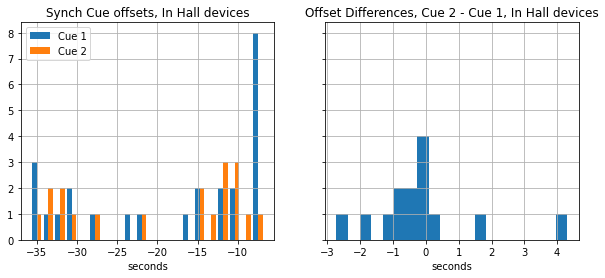

,Means,Medians,Means (abs),Medians (abs),Stds,Mins,Maxs
Offset_1,-17.937600,-13.96,17.937600,13.96,10.886172,-35.30,-6.32
Offset_2,-22.168182,-18.00,22.168182,18.00,12.837142,-53.82,-7.42


In [203]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = [10,4],sharey = True)

A = Synchs['Offset_1'].values
a_heights, a_bins = np.histogram(A[~np.isnan(A)],bins = 20)
A = Synchs['Offset_2'].values
b_heights, b_bins = np.histogram(A[~np.isnan(A)], bins=a_bins)

width = (a_bins[1] - a_bins[0])/2.5
ax1.bar(a_bins[:-1], a_heights, width=width,label='Cue 1')
ax1.bar(b_bins[:-1]+width, b_heights, width=width,label='Cue 2')
ax1.legend()
ax1.grid()
ax1.set_xlabel('seconds')
ax1.set_title('Synch Cue offsets, In Hall devices')


all_offs = Synchs['Offset_1'].abs().values + Synchs['Offset_2'].abs().values
np.nanstd(all_offs)

print('The mean absolute difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).abs().mean()))
print('The median difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).median()))
print('The median absolute difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).abs().median()))
print('The std in difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).std()))
print('The max absolute difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).abs().max()))
print('The max difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).max()))
print('The min difference from first to second cue: ' + str((Synchs["Offset_2"]-Synchs["Offset_1"]).min()))

shift_off = Synchs["Offset_2"]-Synchs["Offset_1"]
shift_off.hist(bins = 20,ax = ax2)
ax2.set_xlabel('seconds',)
ax2.set_title('Offset Differences, Cue 2 - Cue 1, In Hall devices')

plt.savefig('./plots/Offsets_distributions_Remote.png',dpi=300)
plt.show()

align_stats = pd.DataFrame()
align_stats['Means'] = Synchs.mean()
align_stats['Medians'] = Synchs.median()
align_stats['Means (abs)'] = Synchs.abs().mean()
align_stats['Medians (abs)'] = Synchs.abs().median()
align_stats['Stds'] = Synchs.abs().std()
align_stats['Mins'] = Synchs.min()
align_stats['Maxs'] = Synchs.max()
align_stats

# What difference does it make?
Looking at alignment quality in several excerpts after tapping alignment. 

1. Gather all the data, remote and local, in concert time
2. Select excerpts for comparison before and after: synch cue, clapping, gasp to sirens?
3. Tight plots 

In [194]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)
# # device times 10 Hs
ts_dt = pd.date_range(Start_time,End_time, freq='20ms')
ts_ts = np.arange(Start_time.timestamp(),End_time.timestamp(), 0.02)*1000

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.02)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')
#[dt_ct[0],dt_ct[-1]]

concert_times = pd.read_csv(internal_time +'/Events_Full.csv',",",index_col = 0) #SV alignment for beeps
# concert_times

In [186]:
# collect all the aligned devices

# folder of devicewise files for a specific set
folder = internal_mlmotion
devices = os.listdir(folder)

# prime dataframe and constants
aud_df = pd.DataFrame(index = ts_ct)
Dev_aud_df = pd.DataFrame(index = ts_ts)

dev_n = 0
kept_dev = []
gap_t = 1000 # 1 seconds


for devFile in devices:
    if 'Q' in devFile: # aligned of in hall participants  
        # import motion file
        inst_d = pd.read_csv(folder + '/' + devFile)
        inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
        datas = gap_nans(inst_d,1000)
        
        #first get device time
        resampled = pd.DataFrame(index = ts_ts)
        cols = datas.columns
        for col in cols[1:]:
            f = interpolate.interp1d(datas['device_timestamps'], datas[col],fill_value='extrapolate')
            resampled[col] = f(ts_ts)
        # extract 1D accelerometer feature for easy comparison
        b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
        if np.nanmedian(b)>0:
            Dev_aud_df[dev_n] = b/np.nanmedian(b)
        else:
            Dev_aud_df[dev_n] = b/np.nanmean(b)
        
        #second  get concert time
        resampled = pd.DataFrame(index = ts_ct)
        cols = datas.columns
        for col in cols[1:]:
            f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
            resampled[col] = f(ts_ct)
        # extract 1D accelerometer feature for easy comparison
        b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
        if np.nanmedian(b)>0:
            aud_df[dev_n] = b/np.nanmedian(b)
        else:
            aud_df[dev_n] = b/np.nanmean(b)
            
        # increment
        dev_n+=1
        kept_dev.append(devFile)
        
Dev_aud_df.index = ts_dt[:-1]
aud_df.index = dt_ct

[Timestamp('2021-10-26 17:48:02'), Timestamp('2021-10-26 17:48:42')]


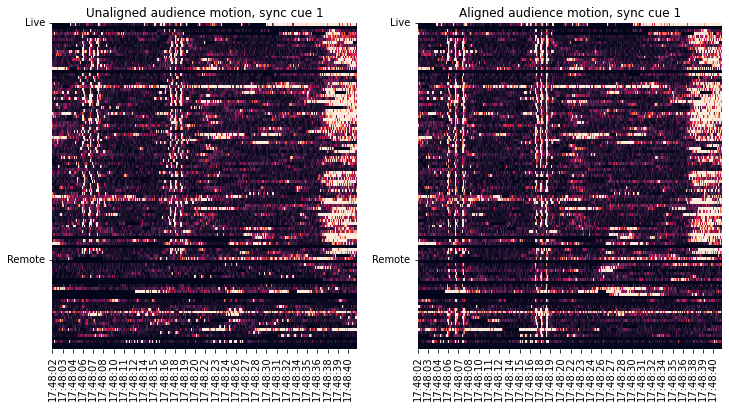

In [193]:
# TODO Make plot that zooms in so we can see the alignment quality
seg_start = pd.to_datetime('2021-10-26 17:48:02+0000').replace(tzinfo=None)
seg_end = pd.to_datetime('2021-10-26 17:48:42+0000').replace(tzinfo=None)

print([seg_start,seg_end])
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = [12,6])

seg_df = Dev_aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)

chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=15,cbar=False)
ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax1.set_title('Unaligned audience motion, sync cue 1')
ax1.set_yticks([0,80])
ax1.set_yticklabels(['Live','Remote'])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)
chart = sns.heatmap(data=seg_df.transpose(), ax=ax2,vmin=0, vmax=15,cbar=False)

freq = int(round(len(seg_df)/len(ax2.get_xticks())))
ax2.set_xticklabels(seg_df.iloc[ax2.get_xticks()].index.strftime("%H:%M:%S"))
ax2.set_title('Aligned audience motion, sync cue 1')
ax2.set_yticks([0,80])
ax2.set_yticklabels(['Live','Remote'])
plt.savefig('./plots/Realigned_All_sync1_50Hz.png',dpi = 300)
plt.show()